In [1]:
import black
import jupyter_black

jupyter_black.load()

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from typing import List, Tuple

import openTSNE as TSNE

In [3]:
# set random seed
np.random.seed(42)

In [4]:
tsne_kwargs = {
    "n_iter": 1000,
    "early_exaggeration": 12,
    "learning_rate": 200,
    "n_jobs": -1,
    "random_state": 42,
    "perplexity": 50,
}

In [5]:
def compute_knn_recall(
    original_data: np.ndarray, tsne_data: np.ndarray, k: int = 10
) -> float:
    """
    Computes the recall of k-nearest neighbors between the original data and the t-SNE data.

    Parameters
    ----------
    original_data : np.ndarray
        The original multidimensional data.
    tsne_data : np.ndarray
        The t-SNE transformed data.
    k : int, optional
        The number of neighbors to consider, by default 7

    Returns
    -------
    float
        The average recall of k-nearest neighbors between the original data and the t-SNE data.

    Notes
    -----

    The formula is taken from: Gove et al. (2022)
    New guidance for using t-SNE: Alternative defaults, hyperparameter selection automation,
    and comparative evaluation,
    Visual Informatics, Volume 6, Issue 2, 2022,

    """
    # Fit kNN on original data
    knn_orig = NearestNeighbors(n_neighbors=k, metric="euclidean")
    knn_orig.fit(original_data)
    orig_neighbors = knn_orig.kneighbors(return_distance=False)

    # Fit kNN on t-SNE data
    knn_tsne = NearestNeighbors(n_neighbors=k, metric="euclidean")
    knn_tsne.fit(tsne_data)
    tsne_neighbors = knn_tsne.kneighbors(return_distance=False)

    # Calculate recall for each point
    recall_scores = []
    for i in range(len(original_data)):
        shared_neighbors = np.intersect1d(orig_neighbors[i], tsne_neighbors[i])
        recall = len(shared_neighbors) / k
        recall_scores.append(recall)

    # Return average recall
    return np.mean(recall_scores)

In [33]:
def compute_optimal_dof(
    raw_data: np.ndarray,
    tsne_data_list: List[TSNE.TSNE],
    dofs: np.ndarray,
    metric: str,
    plot: bool = False,
) -> Tuple[int, float]:
    """
    Computes the optimal degrees of freedom based on the specified metric.

    Parameters
    ----------
    raw_data : np.ndarray
        _description_
    tsne_data_list : List[TSNE.TSNE]
        _description_
    dofs : np.ndarray
        _description_
    metric : str
        _description_
    plot : bool, optional
        _description_, by default False

    Returns
    -------
    Tuple[int, float]
        _description_
    """

    metrics = [
        "KL",
        "kNN recall",
    ]

    assert len(tsne_data_list) == len(
        dofs
    ), "Length of tsne_data_list and dofs must be the same"

    results = {}
    x = np.zeros([len(dofs), len(metrics)])
    print(x.shape)

    if metric == "KL":
        for i in range(len(tsne_data_list)):
            x[i][0] = tsne_data_list[i].kl_divergence

    elif metric == "kNN recall":
        for i in range(len(tsne_data_list)):
            x[i][1] = compute_knn_recall(raw_data, tsne_data_list[i])

    elif metric == "all":
        for i in range(len(tsne_data_list)):
            x[i][0] = tsne_data_list[i].kl_divergence
            x[i][1] = compute_knn_recall(raw_data, tsne_data_list[i])

    results["KL"] = {
        "values": x[0, :],
        "optimal_dof": dofs[np.argmin(x[0, :])],
        "optimal_value": np.min(x[0, :]),
    }
    results["kNN recall"] = {
        "values": x[1, :],
        "optimal_dof": dofs[np.argmax(x[1, :])],
        "optimal_value": np.max(x[1, :]),
    }

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        for i in range(len(metrics)):
            ax[i].plot(dofs, results[metrics[i]]["values"][i], label=metrics[i])
            ax[i].set_xlabel("Degrees of Freedom")
            ax[i].set_ylabel("Metric Value")
            ax[i].legend()
            ax[i].scatter(
                results[metrics[i]]["optimal_dof"],
                results[metrics[i]]["optimal_value"],
                color="red",
                label="Optimal",
            )

        sns.despine()
        plt.show()

    return results

In [8]:
def plot_TSNE(
    tsne_result,
    ax,
    raw_data: np.ndarray = None,
    labels=None,
    display_metrics: bool = False,
):

    def display_KL(x=0.01, y=0.95):
        KL = tsne_result.kl_divergence
        ax.text(
            x,
            y,
            r"$\mathcal{L}$" + f": {KL:.2f}",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            size=8,
            fontweight="bold",
        )

    def display_knn_recall(x=0.01, y=0.95):
        if raw_data is None:
            raise ValueError("raw_data must be provided to compute kNN recall")
        knn_recall = compute_knn_recall(raw_data, tsne_result)
        ax.text(
            x,
            y,
            "kNN Recall" + f": {knn_recall:.2f}",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            size=8,
            fontweight="bold",
        )

    sns.scatterplot(
        x=tsne_result[:, 0],
        y=tsne_result[:, 1],
        hue=labels,
        palette=sns.color_palette("Spectral", as_cmap=True),
        legend=False,
        alpha=0.8,
        size=0.5,
        ax=ax,
    )

    if display_metrics == "KL":
        display_KL()
    elif display_metrics == "knn_recall":
        display_knn_recall()
    elif display_metrics == "all":
        display_KL()
        display_knn_recall(y=0.9)

    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

In [9]:
def generate_swiss_roll(
    n_samples: int = 1000, noise: float = 0.0, plot: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """_summary_

    Parameters
    ----------
    n_samples : int, optional
        number of samples to generate, by default 1000
    noise : float, optional
        add noise to the swiss roll, by default 0.0
    plot : bool, optional
        whether to plot the swiss roll, by default True

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        coordinates of the swiss roll and the color of the points
    """

    sr_points, sr_color = sklearn.datasets.make_swiss_roll(
        n_samples=n_samples, noise=noise, random_state=42
    )
    if plot:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        sns.set(style="white")
        sns.color_palette("hsv", as_cmap=True)
        fig.add_axes(ax)
        ax.scatter(
            sr_points[:, 0],
            sr_points[:, 1],
            sr_points[:, 2],
            c=sr_color,
            cmap="Spectral",
            s=8,
        )
        ax.set_title("Swiss Roll in Ambient Space")
        ax.view_init(azim=-66, elev=12)
        _ = ax.text2D(0.8, 0.05, s=f"n_samples={n_samples}", transform=ax.transAxes)

    return sr_points, sr_color

## Swiss-roll dataset

### N-samples = 5000

In [10]:
sr_points, sr_color = sklearn.datasets.make_swiss_roll(
    n_samples=5000, noise=0.0, random_state=None
)

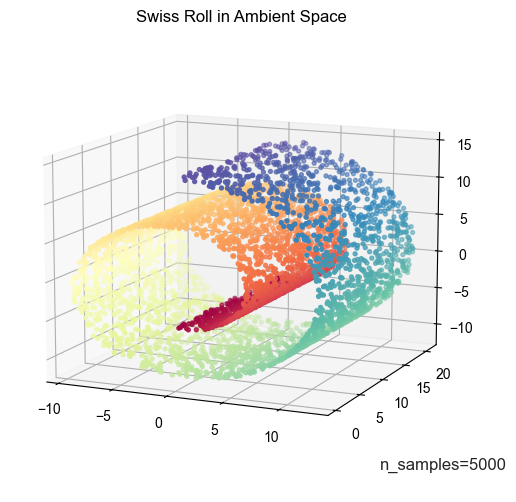

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
sns.set(style="dark")
sns.color_palette("dark", as_cmap=True)
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, cmap="Spectral", s=8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=5000", transform=ax.transAxes)

In [12]:
dofs = np.linspace(1, 10, 10)
tsne_results_sr5000 = []
for dof in dofs:
    tsne = TSNE.TSNE(
        perplexity=30,
        dof=dof,
        verbose=True,
    )
    tsne_results_sr5000.append(tsne.fit(sr_points))

--------------------------------------------------------------------------------
TSNE(dof=1.0, early_exaggeration=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2.69 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.13 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=416.67 for 250 iterations...
Iteration   50, KL divergence 2.9539, 50 iterations in 6.8794 sec
Iteration  100, KL divergence 2.9224, 50 iterations in 6.5140 sec
Iteration  150, KL divergence 2.8432, 50 iterations in 6.2835 sec
Iteration  200, KL divergence 2.7976, 50 iterations in 6.4570 sec
Iteration  250, KL divergence 2.7740, 50 iterations in 6.2719 sec
   --> Time elapsed: 32.41 seconds
===> Running optimization with exaggeration=1.00, lr=5000.00 fo

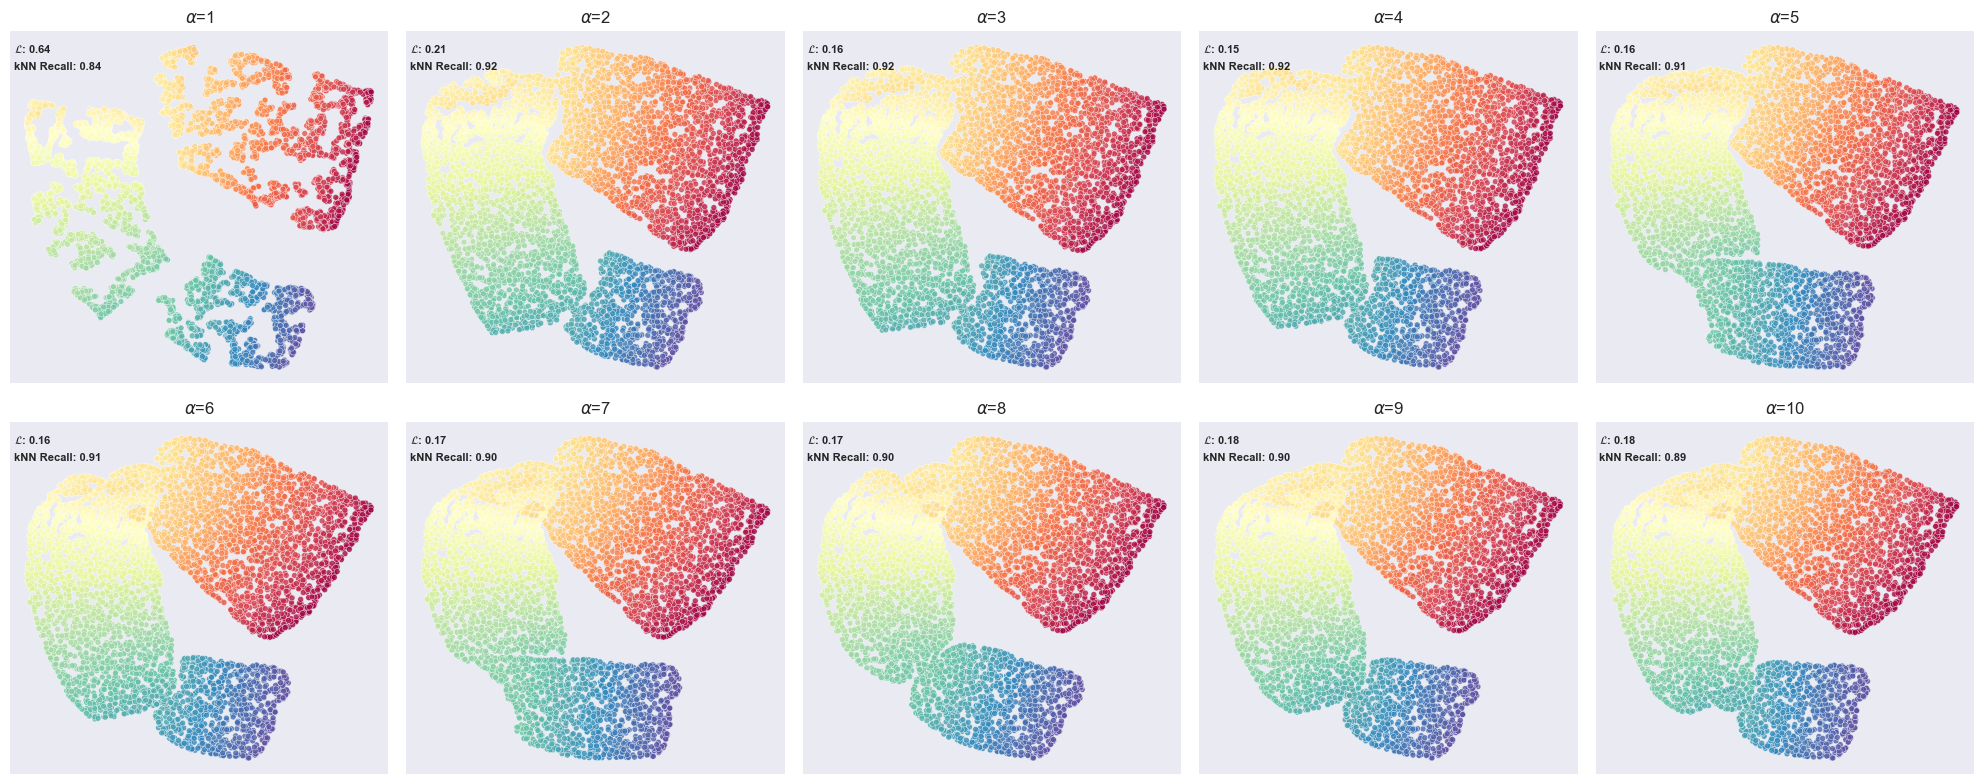

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, dof in enumerate(dofs):
    plot_TSNE(
        tsne_result=tsne_results_sr5000[i],
        ax=axes[i],
        raw_data=sr_points,
        labels=sr_color,
        display_metrics="all",
    )
    axes[i].set_title(r"$\alpha$" + f"={int(dof)}")

(10, 2)


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

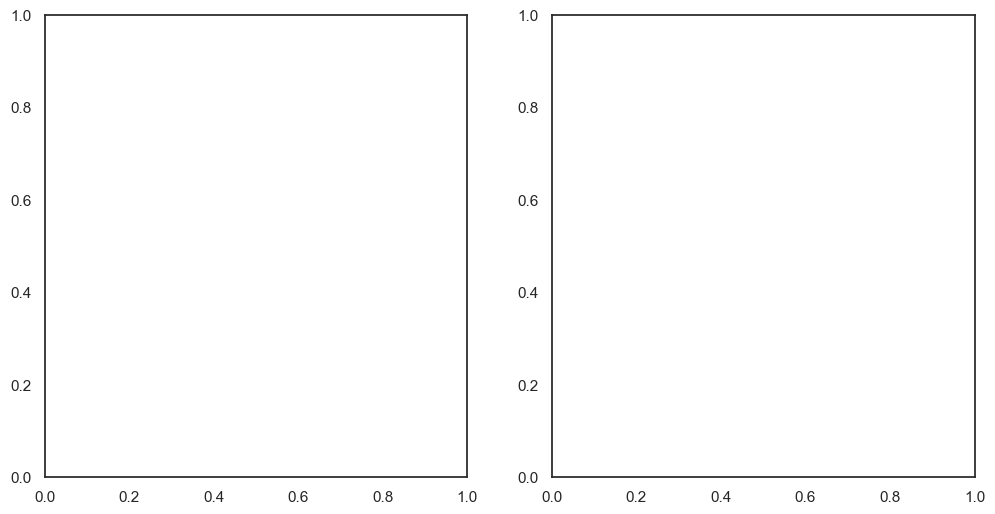

In [34]:
results = compute_optimal_dof(
    raw_data=sr_points,
    tsne_data_list=tsne_results_sr5000,
    dofs=dofs,
    metric="all",
    plot=True,
)

### N-samples = 1000

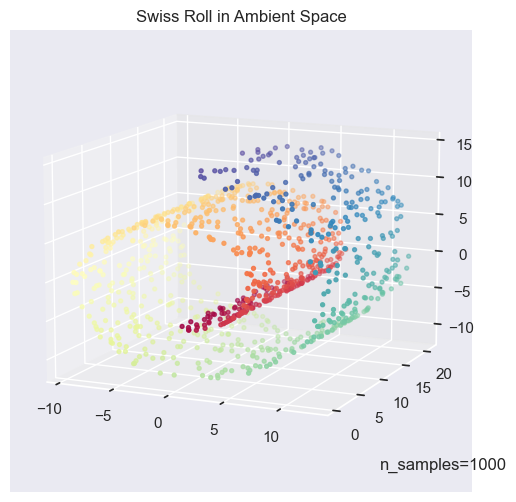

In [15]:
sr_points, sr_color = generate_swiss_roll(n_samples=1000, noise=0.0, plot=True)

In [16]:
dofs = np.linspace(1, 10, 10)
tsne_results_sr1000 = []
for dof in dofs:
    tsne = TSNE.TSNE(
        perplexity=30,
        dof=dof,
        verbose=True,
    )
    tsne_results_sr1000.append(tsne.fit(sr_points))

--------------------------------------------------------------------------------
TSNE(dof=1.0, early_exaggeration=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.53 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=83.33 for 250 iterations...
Iteration   50, KL divergence 2.4960, 50 iterations in 1.0284 sec
Iteration  100, KL divergence 2.5817, 50 iterations in 0.9764 sec
Iteration  150, KL divergence 2.4928, 50 iterations in 0.8812 sec
Iteration  200, KL divergence 2.3156, 50 iterations in 0.9293 sec
Iteration  250, KL divergence 2.3107, 50 iterations in 0.9479 sec
   --> Time elapsed: 4.76 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 

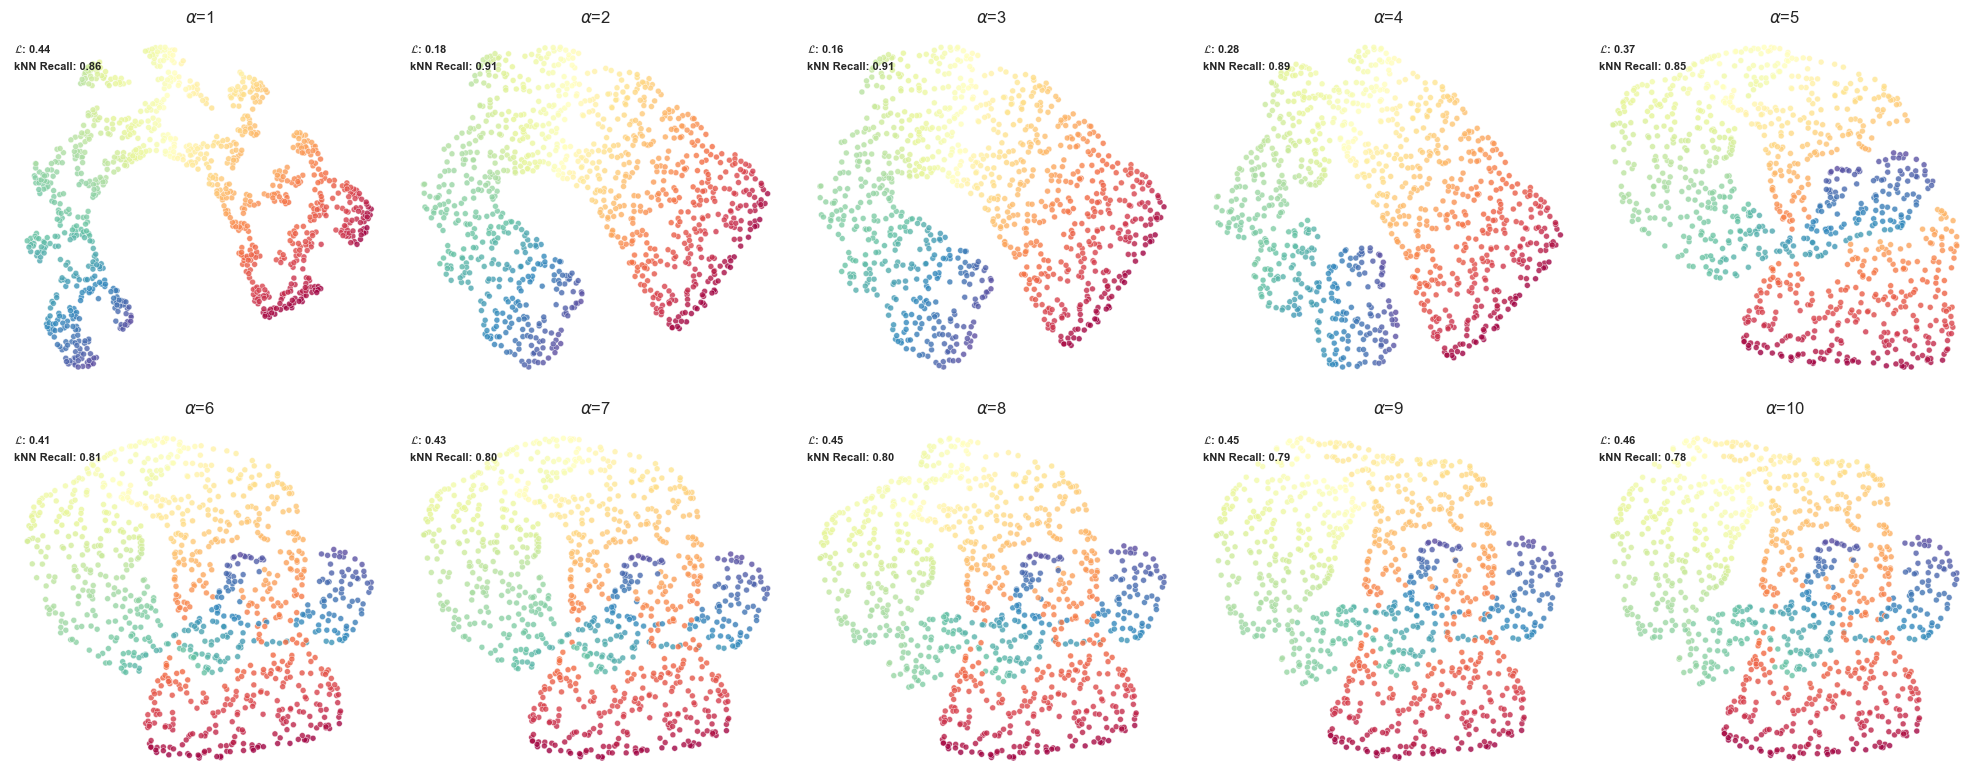

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, dof in enumerate(dofs):
    plot_TSNE(
        tsne_result=tsne_results_sr1000[i],
        ax=axes[i],
        raw_data=sr_points,
        labels=sr_color,
        display_metrics="all",
    )
    axes[i].set_title(r"$\alpha$" + f"={int(dof)}")

(10, 2)


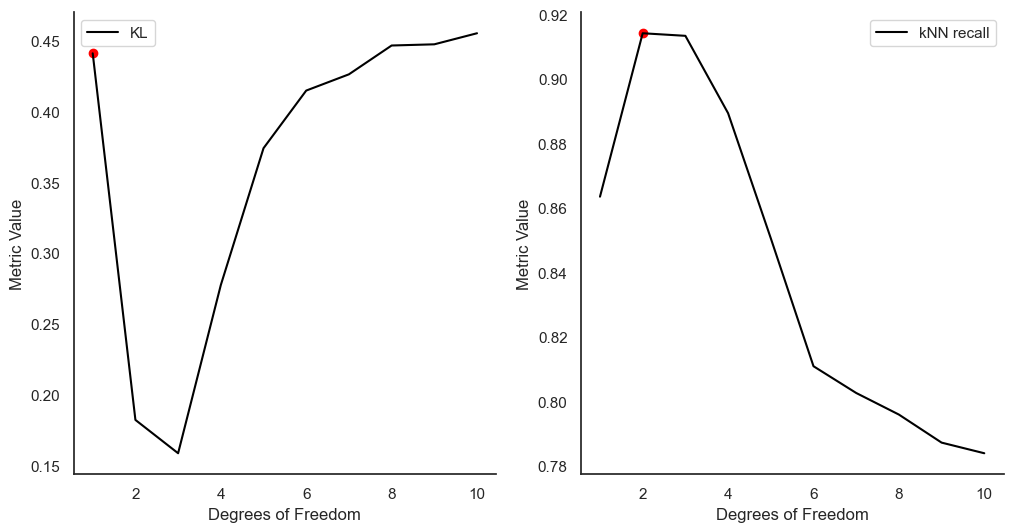

In [18]:
optimal_dof, optimal_kl = compute_optimal_dof(
    raw_data=sr_points,
    tsne_data_list=tsne_results_sr1000,
    dofs=dofs,
    metric="all",
    plot=True,
)

In [19]:
perplexities = [5, 30, 50, 100]
tsne_results_sr1000_pp = [TSNE.TSNE(perplexity=p).fit(sr_points) for p in perplexities]

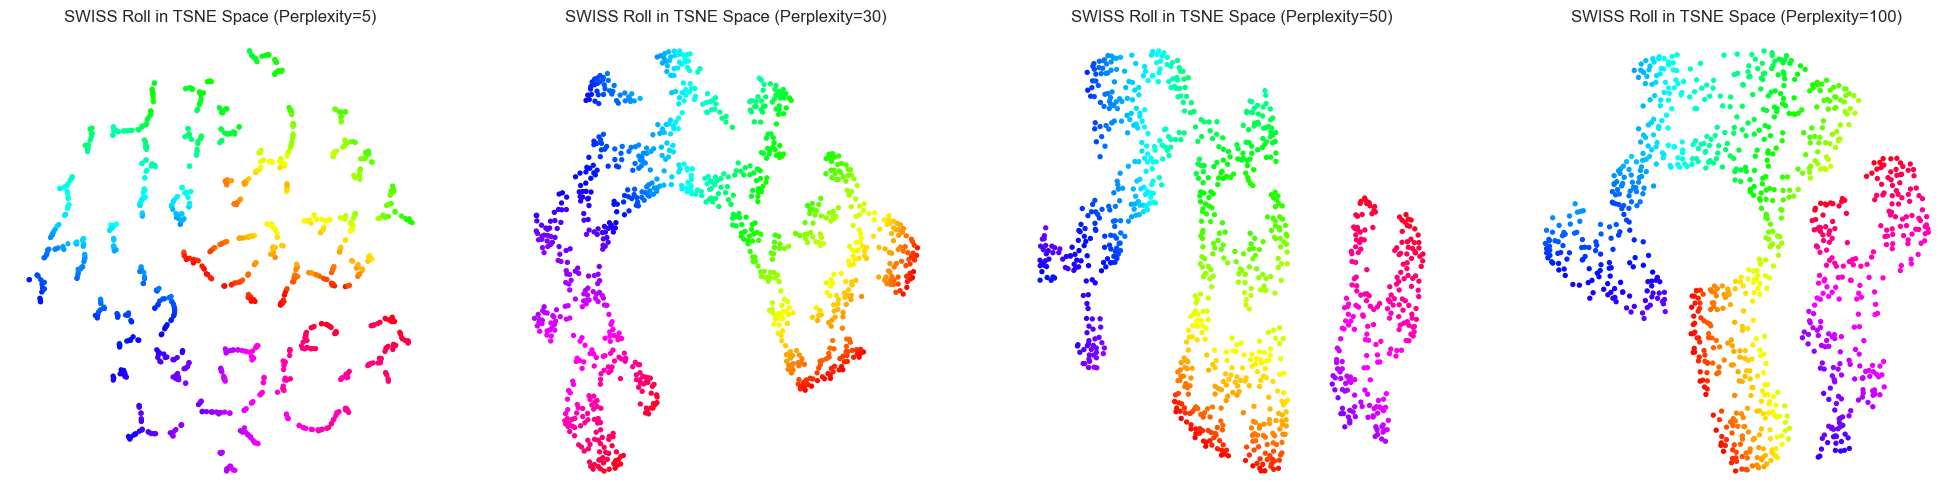

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(25, 6))
for i, p in enumerate(perplexities):

    ax[i].scatter(
        tsne_results_sr1000_pp[i][:, 0],
        tsne_results_sr1000_pp[i][:, 1],
        c=sr_color,
        cmap="hsv",
        s=8,
    )
    ax[i].set_title(f"SWISS Roll in TSNE Space (Perplexity={p})")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    sns.despine(left=True, bottom=True)

## Digits dataset

In [21]:
digits = sklearn.datasets.load_digits(n_class=6)
digit_colors = sns.color_palette("Spectral", as_cmap=True)
X, y = digits.data, digits.target
print(y)
n_samples, n_features = X.shape
n_neighbors = 30

[0 1 2 ... 4 4 0]


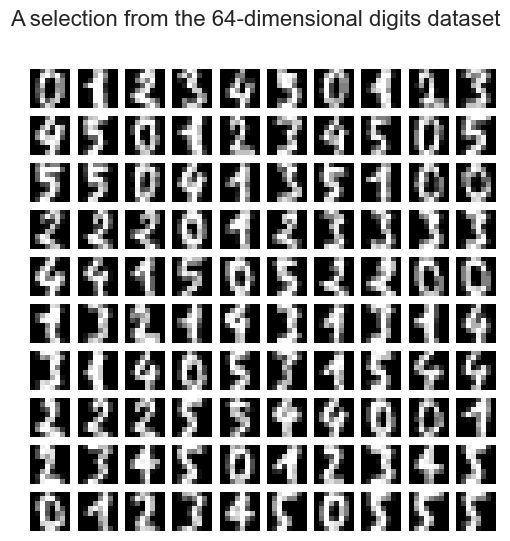

In [22]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap="grey")
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [23]:
X = MinMaxScaler().fit_transform(X)
digits_tsne = TSNE.TSNE(perplexity=30).fit(X)

In [24]:
# add labels to the embedding
digits_tsne = np.hstack([digits_tsne, y[:, np.newaxis]])
print(digits_tsne)

[[ 19.34039984 -35.24972998   0.        ]
 [  9.82030292  16.96132774   1.        ]
 [-12.55955539  19.88284101   2.        ]
 ...
 [ 37.18455554  12.74535515   4.        ]
 [ 36.7831138    9.97443155   4.        ]
 [ 22.21963339 -26.48944206   0.        ]]


/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_1990/2620526160.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


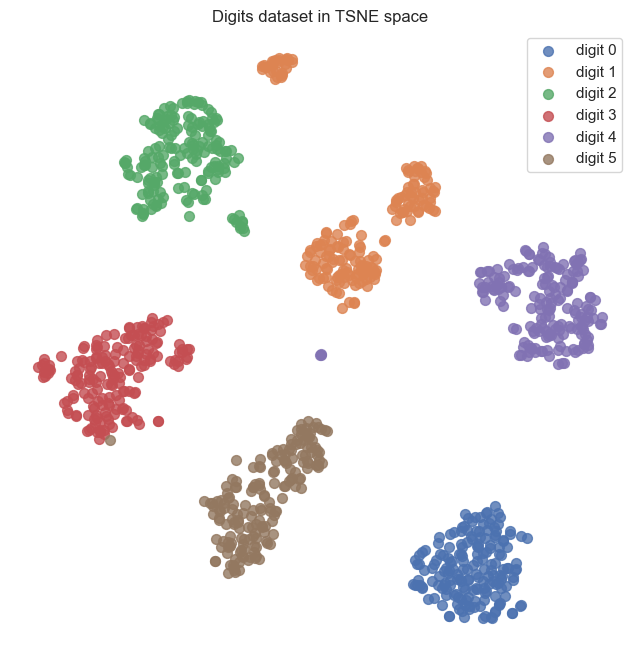

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for n in range(int(digits_tsne[:, 2].max()) + 1):
    ax.scatter(
        digits_tsne[digits_tsne[:, 2] == n, 0],
        digits_tsne[digits_tsne[:, 2] == n, 1],
        s=50,
        alpha=0.8,
        cmap=digit_colors,
        label=f"digit {n}",
    )
sns.despine(left=True, bottom=True)
ax.set_title("Digits dataset in TSNE space")
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

In [26]:
dofs = np.linspace(0, 2, 10)
tsne_results_digits = []
for dof in dofs:
    tsne = TSNE.TSNE(
        perplexity=30,
        dof=dof,
        verbose=True,
    )
    tsne_results_digits.append(tsne.fit(X))

--------------------------------------------------------------------------------
TSNE(dof=0.0, early_exaggeration=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.33 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=90.25 for 250 iterations...
Iteration   50, KL divergence 3.3266, 50 iterations in 1.2936 sec
Iteration  100, KL divergence 3.1993, 50 iterations in 0.8699 sec
Iteration  150, KL divergence 3.1228, 50 iterations in 0.6952 sec
Iteration  200, KL divergence 3.0928, 50 iterations in 0.6427 sec
Iteration  250, KL divergence 3.0374, 50 iterations in 0.6054 sec
   --> Time elapsed: 4.11 seconds
===> Running optimization with exaggeration=1.00, lr=1083.00 for 

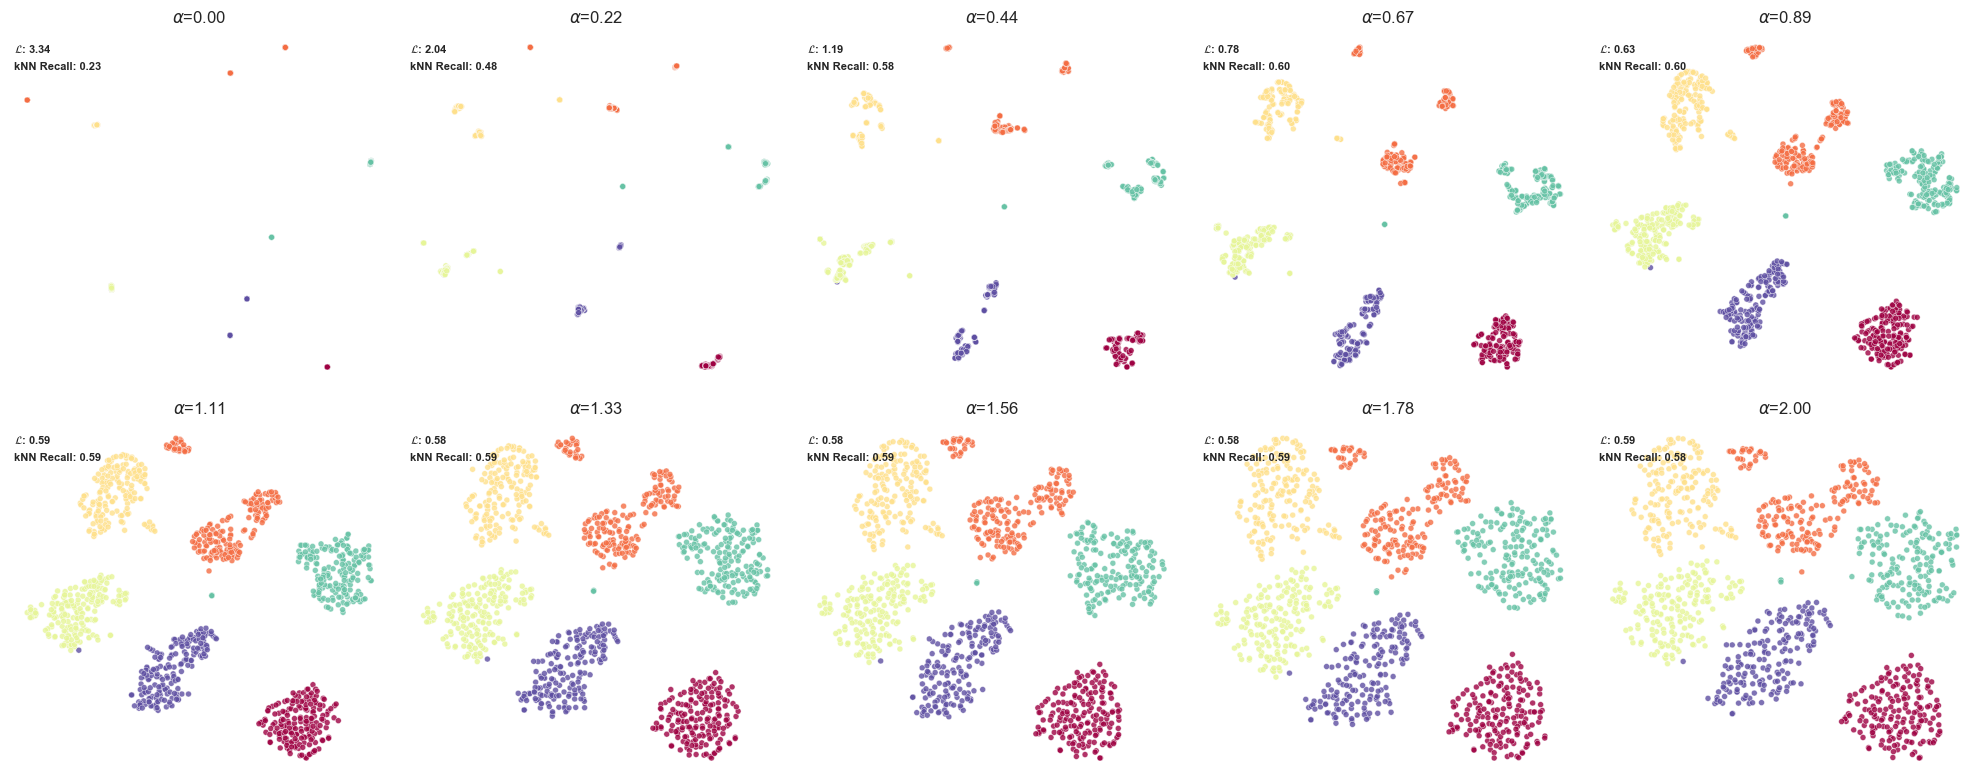

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, dof in enumerate(dofs):
    plot_TSNE(
        tsne_result=tsne_results_digits[i],
        ax=axes[i],
        labels=y,
        raw_data=X,
        display_metrics="all",
    )
    axes[i].set_title(r"$\alpha$" + f"={dof:.2f}")

(10, 2)


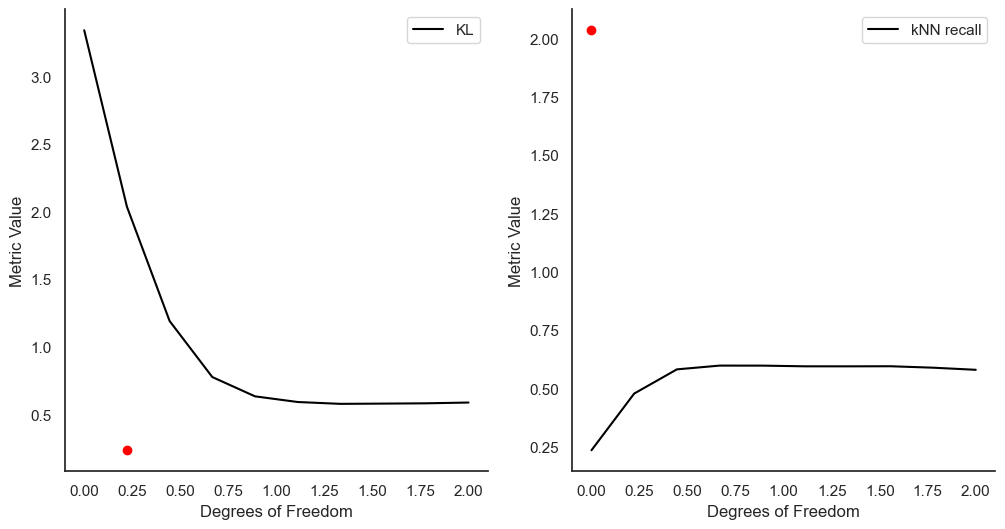

In [28]:
optimal_dof, optimal_kl = compute_optimal_dof(
    raw_data=X, tsne_data_list=tsne_results_digits, dofs=dofs, metric="all", plot=True
)